In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

import requests
import zipfile
import os
import io
import shutil
from shutil import copyfile
import random

In [2]:
data_dir = 'backup_data/dataset-resized'

categories = ["BATTERY", "BIOLOGICAL", "CLOTHES","CARDBOARD", "GLASS", "METAL", "PAPER", "PLASTIC", "NON_RECYCLE", "SHOES"]

In [3]:
for category in categories:
    data_category = os.path.join(data_dir, category)
    print(f"There are {len(os.listdir(data_category))} images of {category}")

There are 945 images of BATTERY
There are 985 images of BIOLOGICAL
There are 1865 images of CLOTHES
There are 1294 images of CARDBOARD
There are 1905 images of GLASS
There are 1179 images of METAL
There are 1644 images of PAPER
There are 1347 images of PLASTIC
There are 834 images of NON_RECYCLE
There are 1977 images of SHOES


In [4]:
# Create tmp dir
root_dir = './dataset/tmp'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# CREATE FUNCTION: train_test_dirs 
def create_train_test_dirs(root_path):
    pass
    train_dir = os.path.join(root_path, 'train')
    test_dir = os.path.join(root_path, 'test')

    os.makedirs(train_dir)
    os.makedirs(test_dir)

    # Train subdir
    for category in categories:
        train_category_dir = os.path.join(train_dir, category)
        test_category_dir = os.path.join(test_dir, category)
        
        if not os.path.exists(train_category_dir):
            os.makedirs(train_category_dir)
        
        if not os.path.exists(test_category_dir):
            os.makedirs(test_category_dir)

In [5]:
try:
    create_train_test_dirs(root_path=root_dir)
except FileExistsError:
    print('File Sudah Ada')

In [6]:
# Cek dir
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

./dataset/tmp\test
./dataset/tmp\train
./dataset/tmp\test\BATTERY
./dataset/tmp\test\BIOLOGICAL
./dataset/tmp\test\CARDBOARD
./dataset/tmp\test\CLOTHES
./dataset/tmp\test\GLASS
./dataset/tmp\test\METAL
./dataset/tmp\test\NON_RECYCLE
./dataset/tmp\test\PAPER
./dataset/tmp\test\PLASTIC
./dataset/tmp\test\SHOES
./dataset/tmp\train\BATTERY
./dataset/tmp\train\BIOLOGICAL
./dataset/tmp\train\CARDBOARD
./dataset/tmp\train\CLOTHES
./dataset/tmp\train\GLASS
./dataset/tmp\train\METAL
./dataset/tmp\train\NON_RECYCLE
./dataset/tmp\train\PAPER
./dataset/tmp\train\PLASTIC
./dataset/tmp\train\SHOES


In [7]:
# CREATE FUNCTION: split_data
def split_data(DATA_DIR, TRAIN_DIR, TEST_DIR, SPLIT_SIZE):
    pass
    data_source = os.listdir(DATA_DIR)
    
    random.sample(data_source, len(data_source))

    split_size = int(len(data_source) * SPLIT_SIZE)

    # split
    data_train = data_source[:split_size]
    data_test = data_source[split_size:]

    def check_length(file):
        return os.path.getsize(os.path.join(DATA_DIR, file)) > 0
    
    for file in data_train:
        if check_length(file):
            copyfile(os.path.join(DATA_DIR, file), os.path.join(TRAIN_DIR, file))
        else:
            print(f"{file} is zero length, so ingnoring.")

    for file in data_test:
        if check_length(file):
            copyfile(os.path.join(DATA_DIR, file), os.path.join(TEST_DIR, file))
        else:
            print(f"{file} is zero length, so ingnoring.")

In [8]:
# Define DATA_DIR
BATTERY_DIR = './backup_data/dataset-resized/battery'
BIOLOGICAL_DIR = './backup_data/dataset-resized/biological'
CARDBOARD_DIR = './backup_data/dataset-resized/cardboard'
CLOTHES_DIR = './backup_data/dataset-resized/clothes'
GLASS_DIR = './backup_data/dataset-resized/glass'
METAL_DIR = './backup_data/dataset-resized/metal'
PAPER_DIR = './backup_data/dataset-resized/paper'
PLASTIC_DIR = './backup_data/dataset-resized/plastic'
NON_RECYCLE_DIR = './backup_data/dataset-resized/non_recycle'
SHOES_DIR = './backup_data/dataset-resized/shoes'

In [9]:
# Define TRAIN_DIR
TRAIN_DIR = './dataset/tmp/train'

TRAIN_BATTERY_DIR = os.path.join(TRAIN_DIR, "battery/")
TRAIN_BIOLOGICAL_DIR = os.path.join(TRAIN_DIR, "biological/")
TRAIN_CARDBOARD_DIR = os.path.join(TRAIN_DIR, "cardboard/")
TRAIN_CLOTHES_DIR = os.path.join(TRAIN_DIR, "clothes/")
TRAIN_GLASS_DIR = os.path.join(TRAIN_DIR, "glass/")
TRAIN_METAL_DIR = os.path.join(TRAIN_DIR, "metal/")
TRAIN_PAPER_DIR = os.path.join(TRAIN_DIR, "paper/")
TRAIN_PLASTIC_DIR = os.path.join(TRAIN_DIR, "plastic/")
TRAIN_NON_RECYCLE_DIR = os.path.join(TRAIN_DIR, "non_recycle/")
TRAIN_SHOES_DIR = os.path.join(TRAIN_DIR, "shoes/")

In [10]:
# Define TEST_DIR
TEST_DIR = './dataset/tmp/test'

TEST_BATTERY_DIR = os.path.join(TEST_DIR, "battery/")
TEST_BIOLOGICAL_DIR = os.path.join(TEST_DIR, "biological/")
TEST_CARDBOARD_DIR = os.path.join(TEST_DIR, "cardboard/")
TEST_CLOTHES_DIR = os.path.join(TEST_DIR, "clothes/")
TEST_GLASS_DIR = os.path.join(TEST_DIR, "glass/")
TEST_METAL_DIR = os.path.join(TEST_DIR, "metal/")
TEST_PAPER_DIR = os.path.join(TEST_DIR, "paper/")
TEST_PLASTIC_DIR = os.path.join(TEST_DIR, "plastic/")
TEST_NON_RECYCLE_DIR = os.path.join(TEST_DIR, "non_recycle/")
TEST_SHOES_DIR = os.path.join(TEST_DIR, "shoes/")

In [11]:
# Empty directories in case you run the cell multiple times
# TRAIN
if len(os.listdir(TRAIN_CARDBOARD_DIR)) > 0:
  for file in os.scandir(TRAIN_CARDBOARD_DIR):
    os.remove(file.path)
if len(os.listdir(TRAIN_GLASS_DIR)) > 0:
  for file in os.scandir(TRAIN_GLASS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAIN_METAL_DIR)) > 0:
  for file in os.scandir(TRAIN_METAL_DIR):
    os.remove(file.path)
if len(os.listdir(TRAIN_PAPER_DIR)) > 0:
  for file in os.scandir(TRAIN_PAPER_DIR):
    os.remove(file.path)
if len(os.listdir(TRAIN_PLASTIC_DIR)) > 0:
  for file in os.scandir(TRAIN_PLASTIC_DIR):
    os.remove(file.path)
if len(os.listdir(TRAIN_NON_RECYCLE_DIR)) > 0:
  for file in os.scandir(TRAIN_NON_RECYCLE_DIR):
    os.remove(file.path)
if len(os.listdir(TRAIN_BATTERY_DIR)) > 0:
  for file in os.scandir(TRAIN_BATTERY_DIR):
    os.remove(file.path)
if len(os.listdir(TRAIN_BIOLOGICAL_DIR)) > 0:
  for file in os.scandir(TRAIN_BIOLOGICAL_DIR):
    os.remove(file.path) 
if len(os.listdir(TRAIN_SHOES_DIR)) > 0:
  for file in os.scandir(TRAIN_SHOES_DIR):
    os.remove(file.path)


# TEST
if len(os.listdir(TEST_CARDBOARD_DIR)) > 0:
  for file in os.scandir(TEST_CARDBOARD_DIR):
    os.remove(file.path)
if len(os.listdir(TEST_GLASS_DIR)) > 0:
  for file in os.scandir(TEST_GLASS_DIR):
    os.remove(file.path)
if len(os.listdir(TEST_METAL_DIR)) > 0:
  for file in os.scandir(TEST_METAL_DIR):
    os.remove(file.path)
if len(os.listdir(TEST_PAPER_DIR)) > 0:
  for file in os.scandir(TEST_PAPER_DIR):
    os.remove(file.path)
if len(os.listdir(TEST_PLASTIC_DIR)) > 0:
  for file in os.scandir(TEST_PLASTIC_DIR):
    os.remove(file.path)
if len(os.listdir(TEST_NON_RECYCLE_DIR)) > 0:
  for file in os.scandir(TEST_NON_RECYCLE_DIR):
    os.remove(file.path)
if len(os.listdir(TEST_BATTERY_DIR)) > 0:
  for file in os.scandir(TEST_BATTERY_DIR):
    os.remove(file.path)
if len(os.listdir(TEST_BIOLOGICAL_DIR)) > 0:
  for file in os.scandir(TEST_BIOLOGICAL_DIR):
    os.remove(file.path)
if len(os.listdir(TEST_SHOES_DIR)) > 0:
  for file in os.scandir(TEST_SHOES_DIR):
    os.remove(file.path)

In [12]:
if len(os.listdir(TRAIN_CLOTHES_DIR)) > 0:
  for file in os.scandir(TRAIN_CLOTHES_DIR):
    os.remove(file.path)
if len(os.listdir(TEST_CLOTHES_DIR)) > 0:
  for file in os.scandir(TEST_CLOTHES_DIR):
    os.remove(file.path)

In [13]:
# DO: Data Split 
SPLIT_SIZE = .8

directories = [
    (BATTERY_DIR, TRAIN_BATTERY_DIR, TEST_BATTERY_DIR),
    (BIOLOGICAL_DIR, TRAIN_BIOLOGICAL_DIR, TEST_BIOLOGICAL_DIR),
    (CLOTHES_DIR, TRAIN_CLOTHES_DIR, TEST_CLOTHES_DIR),
    (CARDBOARD_DIR, TRAIN_CARDBOARD_DIR, TEST_CARDBOARD_DIR),
    (GLASS_DIR, TRAIN_GLASS_DIR, TEST_GLASS_DIR),
    (METAL_DIR, TRAIN_METAL_DIR, TEST_METAL_DIR),
    (PAPER_DIR, TRAIN_PAPER_DIR, TEST_PAPER_DIR),
    (PLASTIC_DIR, TRAIN_PLASTIC_DIR, TEST_PLASTIC_DIR),
    (NON_RECYCLE_DIR, TRAIN_NON_RECYCLE_DIR, TEST_NON_RECYCLE_DIR),
    (SHOES_DIR, TRAIN_SHOES_DIR, TEST_SHOES_DIR)
]

for source_dir, train_dir, test_dir in directories:
    split_data(source_dir, train_dir, test_dir, SPLIT_SIZE)

In [14]:
# Training Data
train_directories = [TRAIN_SHOES_DIR,TRAIN_BIOLOGICAL_DIR,TRAIN_BATTERY_DIR,TRAIN_CLOTHES_DIR,TRAIN_CARDBOARD_DIR, TRAIN_GLASS_DIR, TRAIN_METAL_DIR, TRAIN_PAPER_DIR, TRAIN_PLASTIC_DIR, TRAIN_NON_RECYCLE_DIR]

for train_dir in train_directories:
    print(f"There are {len(os.listdir(train_dir))} images")

There are 1581 images
There are 788 images
There are 756 images
There are 1492 images
There are 1035 images
There are 1524 images
There are 943 images
There are 1315 images
There are 1077 images
There are 667 images


In [15]:
# Testing Data
test_directories = [TEST_SHOES_DIR,TEST_BIOLOGICAL_DIR,TEST_BATTERY_DIR,TEST_CLOTHES_DIR,TEST_CARDBOARD_DIR, TEST_GLASS_DIR, TEST_METAL_DIR, TEST_PAPER_DIR, TEST_PLASTIC_DIR, TEST_NON_RECYCLE_DIR]

for test_dir in test_directories:
    print(f"There are {len(os.listdir(test_dir))} images")

There are 396 images
There are 197 images
There are 189 images
There are 373 images
There are 259 images
There are 381 images
There are 236 images
There are 329 images
There are 270 images
There are 167 images


In [16]:
# CREATE FUNCTION: train_test_generators
def train_test_generators(TRAIN_DIR, TEST_DIR):
    # Train
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       rotation_range=40,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                        batch_size=20,
                                                        class_mode='categorical',
                                                        target_size=(256,256))
    
    # Test
    test_datagen = ImageDataGenerator(rescale=1/255)

    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                        batch_size=20,
                                                        class_mode='categorical',
                                                        target_size=(256,256))
    return train_generator, test_generator

In [17]:
train_generator, test_generator = train_test_generators(TRAIN_DIR, TEST_DIR)

Found 11178 images belonging to 10 classes.
Found 2797 images belonging to 10 classes.


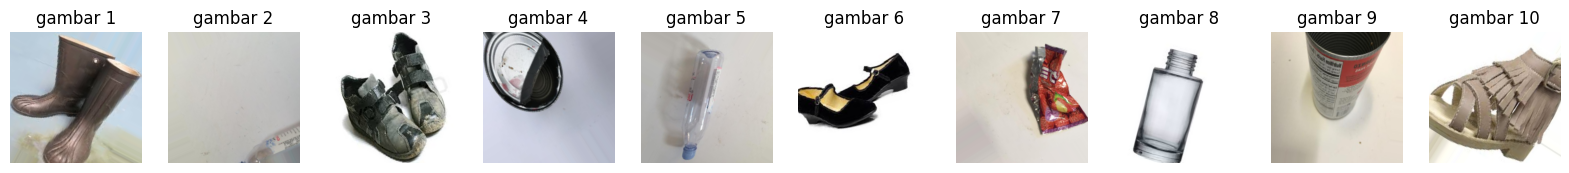

In [18]:
#visualize data augment
def visualize_augmented_data(train_generator, num_images=10):
    sample_images, _ = next(train_generator)  
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    
    for i in range(num_images):
        axes[i].imshow(sample_images[i])
        axes[i].axis('off')
        axes[i].set_title(f"gambar {i+1}")
    
    plt.show()

visualize_augmented_data(train_generator, num_images=10)

In [19]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Define the filepath with the .keras extension
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model = create_model()

In [25]:
model = create_model()

history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/20
559/559 ━━━━━━━━━━━━━━━━━━━━ 253s 447ms/step - accuracy: 0.2804 - loss: 2.1447 - val_accuracy: 0.4011 - val_loss: 1.7349
Epoch 2/20
559/559 ━━━━━━━━━━━━━━━━━━━━ 289s 514ms/step - accuracy: 0.4835 - loss: 1.5054 - val_accuracy: 0.4362 - val_loss: 1.7150
Epoch 3/20
559/559 ━━━━━━━━━━━━━━━━━━━━ 288s 512ms/step - accuracy: 0.5621 - loss: 1.3325 - val_accuracy: 0.4898 - val_loss: 1.4652
Epoch 4/20
559/559 ━━━━━━━━━━━━━━━━━━━━ 339s 603ms/step - accuracy: 0.5900 - loss: 1.2297 - val_accuracy: 0.5324 - val_loss: 1.3901
Epoch 5/20
559/559 ━━━━━━━━━━━━━━━━━━━━ 316s 559ms/step - accuracy: 0.6175 - loss: 1.1308 - val_accuracy: 0.5173 - val_loss: 1.4193
Epoch 6/20
559/559 ━━━━━━━━━━━━━━━━━━━━ 289s 512ms/step - accuracy: 0.6362 - loss: 1.1039 - val_accuracy: 0.5602 - val_loss: 1.3441
Epoch 7/20
559/559 ━━━━━━━━━━━━━━━━━━━━ 281s 500ms/step - accuracy: 0.6373 - loss: 1.0858 - val_accuracy: 0.5642 - val_loss: 1.3075
Epoch 8/20
559/559 ━━━━━━━━━━━━━━━━━━━━ 318s 565ms/step - accuracy: 0.6570 -

In [4]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [5]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

    tf.saved_model.save(model, 'saved_model')

NameError: name 'tf' is not defined